# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [6]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np
import calendar

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [2]:
## For line graph: using data before 2015
# import data
data = pd.DataFrame(pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv'))
data = data[data['Date'] < '2015-01-01'] # all data before 2015

# Find maxiums for each day across station
minTemp = data.groupby('Date')['Data_Value'].min()
maxTemp = data.groupby('Date')['Data_Value'].max()

# Remove 02-29
minTemp = minTemp[minTemp.index != '2008-02-29']
minTemp = minTemp[minTemp.index != '2012-02-29']
maxTemp = maxTemp[maxTemp.index != '2008-02-29']
maxTemp = maxTemp[maxTemp.index != '2012-02-29']

# Find maxs and mins for each day across year
minTempdf = pd.DataFrame(minTemp)
minTempdf['Day'] = minTempdf.index
monDay = []

# re-arrange date format into MM-DD
for day in minTempdf['Day']:
    monDay.append(str(day.split('-')[1]) + str(day.split('-')[2]))

#  get min temp for each day across year
minTempdf['Day'] = monDay
minDay = .1*(minTempdf.groupby('Day')['Data_Value'].min()) # because original temps were logged as tenths of Celsius

# get max temp for each day across year
maxTempdf = pd.DataFrame(maxTemp)
maxTempdf['Day'] = monDay
maxDay = .1*(maxTempdf.groupby('Day')['Data_Value'].max())

In [4]:


## For scatter plot: using data of 2015
# data of 2015
data = pd.DataFrame(pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv'))
Temp15 = data[data['Date']>'2014-12-31']

# min & max temps across stations for each day in 2015
min15 = pd.DataFrame(.1*(Temp15.groupby('Date')['Data_Value'].min()))
max15 = pd.DataFrame(.1*(Temp15.groupby('Date')['Data_Value'].max()))
monDay15 = pd.Series(monDay).unique()
min15['Day'] = monDay15
max15['Day'] = monDay15
min15.reset_index(inplace = True)
min15.set_index('Day',inplace = True)
max15.reset_index(inplace = True)
max15.set_index('Day',inplace = True)

# series to DF
mindf = pd.DataFrame(minDay)
maxdf = pd.DataFrame(maxDay)

# Find out maximums and mininums broken in 15
Allmin = pd.merge(mindf,min15,left_index = True,right_index = True)
Allmin = pd.DataFrame(Allmin[Allmin['Data_Value_y'] < Allmin['Data_Value_x']]['Data_Value_y']) # only keep data when minimum record broken in 15
Allmax = pd.merge(maxdf,max15,left_index = True,right_index = True)
Allmax = pd.DataFrame(Allmax[Allmax['Data_Value_y'] > Allmax['Data_Value_x']]['Data_Value_y'])

# reset indices so can use index for plottting 
mindf.reset_index(inplace = True)
maxdf.reset_index(inplace = True)
Allmin.reset_index(inplace = True)
Allmax.reset_index(inplace = True)

In [7]:
## For labels
# define a function to convert MM-DD to Jan-DD so that interpretable
def str_to_month_day(x):
    x['Month-Day'] = None
    for i in np.arange(len(x)):
        if int(x['Day'][i][0:2]) < 10:
            x['Month-Day'][i] = calendar.month_name[int(x['Day'][i][1])] + x['Day'][i][2:]
        else: x['Month-Day'][i] = calendar.month_name[int(x['Day'][i][0:2])] + x['Day'][i][2:]
    return x

# apply function
mindf = str_to_month_day(mindf)

# used for x-aixs labels
minLen = np.arange(len(mindf))
indices = []
labels = []
for i in minLen:
    if mindf.iloc[i]['Day'][2:] == '01':
        indices.append(i)
        labels.append(mindf.iloc[i]['Month-Day'][0:3] + mindf.iloc[i]['Month-Day'][-2:])

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


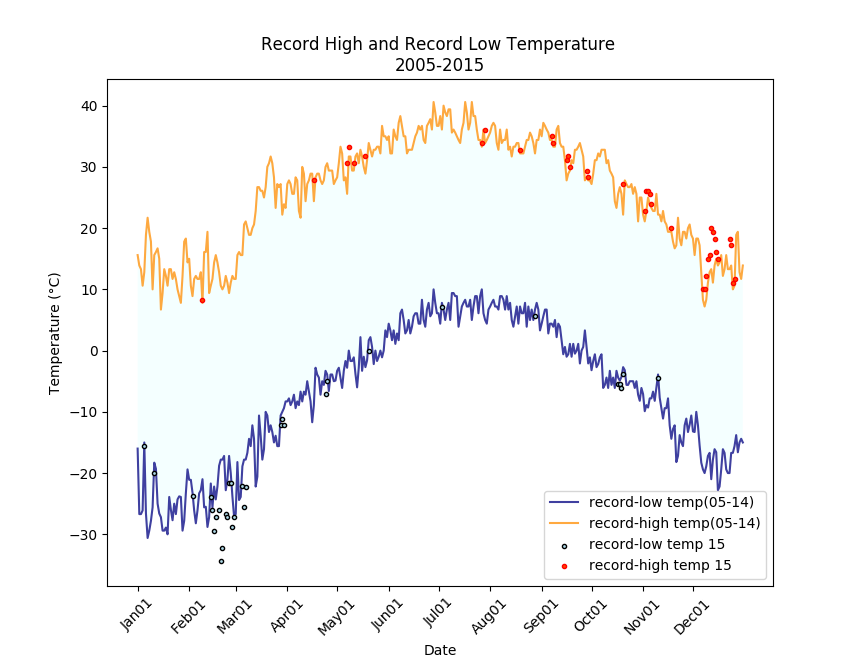

In [18]:
%matplotlib notebook
# plot lines
low_line = plt.plot(minDay.values,'-',linewidth = 1.5,color = 'navy',alpha = .75,label = 'record-low temp(05-14)')
high_line = plt.plot(maxDay.values,linewidth = 1.5,color = 'darkorange',alpha = .75, label = 'record-high temp(05-14)')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.title('Record High and Record Low Temperature \n2005-2015')
ax = plt.gca()
ax.fill_between(range(len(minDay)),minDay,maxDay,facecolor='azure',alpha = .7,zorder = 1) # color in-between area

# scatterplot
minInd = pd.merge(mindf,Allmin,how = 'outer',indicator = True)
minInd = minInd[minInd['_merge'] == 'both'].index # indices for minimum temp broken in 15
plt.scatter(minInd,Allmin['Data_Value_y'],marker = '.',c='lightblue',edgecolors='k',zorder = 10,label = 'record-low temp 15')
maxInd = pd.merge(maxdf,Allmax,how = 'outer',indicator = True)
maxInd = maxInd[maxInd['_merge'] == 'both'].index
plt.scatter(maxInd,Allmax['Data_Value_y'],marker = '.',c='orangered',edgecolors='red',zorder = 10,label = 'record-high temp 15')

# ajust legend and ticks
plt.legend(loc = 'best')
ax.set_xticks(ticks = indices)
ax.set_xticklabels(labels= labels) # label x-axis
plt.xticks(rotation = 45) # rotate x-ticks
tempRecord = plt.savefig # save pics